# Working with Star Formation Histories

In this example we will see how to create a star formation history that contains information about the star formation rate and properties of the stellar population over time. Each SFH object contains information about four different variables that can change over time:

* Star Formation Rate (SFR), typically measured as Msun/yr dictates how much stellar mass is formed per unit time. There are some utilities in the SFH module to compute some typical shapes of SFR. It can also be set up by the user using `sfr_custom`.
* Metallicity, in dex
* [alpha/Fe], in dex
* IMF slope

Once the SFH is completely described, it can be given as an input to a SSP library (such as MILES) to generate the associated spectra.

## Changing `milespy` configuration

The configuration of `milespy` can be changed either from a configuration file or directly with environent variables.
The most important one is to define in which **pre-existing** folder the repository are located.

Do not worry! If it can not find the hdf5 files, it will try to download them automatically.

In [1]:
import os
os.environ['MILESPY_REPOSITORY_FOLDER'] = '/tmp/'

## Initialize

Generate the base sfh object, which then can be modified to obtain the desired star formation history and the associated spectra.

## Configure
* Select the age range we want

In [2]:
from milespy import SFH
import astropy.units as u
import numpy as np
sfh = SFH(
        time = np.linspace(0.03, 13.5, 30) << u.Gyr
)

* Define the SFR

In [3]:
sfh.sfr_tau(start=11*u.Gyr, tau=1.5*u.Gyr, mass=1e10*u.Msun)

* Metallicity evolution

In [4]:
sfh.met_sigmoid(start=-2.1*u.dex, end=0.2*u.dex, tc=10*u.Gyr, gamma=2.0/u.Gyr)

* [alpha/Fe] evolution

In [5]:
sfh.alpha_sigmoid(start=0.4*u.dex, end=0.0*u.dex, tc=10*u.Gyr)

* IMF evolution

In [6]:
sfh.imf_linear(start=0.5, end=2.3, t_start=11.5*u.Gyr, t_end=9.0*u.Gyr)

## Explore the SFH

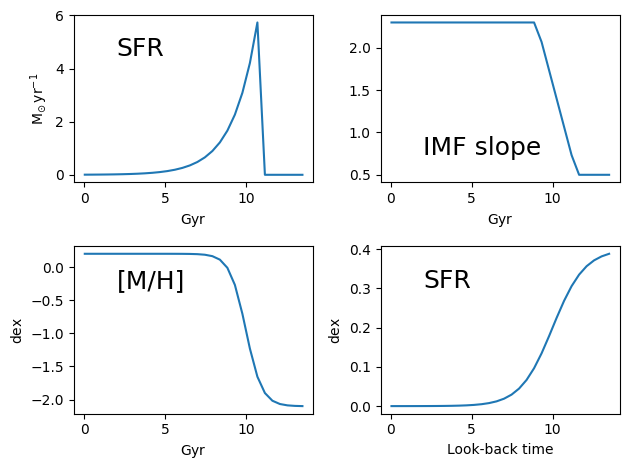

In [7]:
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support
quantity_support()

f, axs = plt.subplots(2,2)
axs[0,1].plot(sfh.time, sfh.imf, label="IMF slope")
axs[1,0].plot(sfh.time, sfh.met, label="[M/H]")
axs[0,0].plot(sfh.time, sfh.sfr, label="SFR")
axs[1,1].plot(sfh.time, sfh.alpha, label="SFR")

for ax in axs.flatten():
    ax.legend(fontsize=18, fancybox=False, frameon=False, handlelength=0)
plt.xlabel("Look-back time")
plt.tight_layout()


## Generate the predictions

In [8]:
from milespy import SSPLibrary
miles = SSPLibrary(
        source="MILES_SSP",
        version="9.1",
        imf_type="bi",
        isochrone="T",
)
pred = miles.from_sfh(sfh)

milespy.repository: Unable to locate repository


Do you want to download the MILES_SSP_v9.1 repository? [y/n]:  y


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1.24G/1.24G [00:14<00:00, 88.5MB/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.54it/s]


## Explore the results

In [9]:
print("Mass-weighted age", pred.age)
print("Mass-weighted [M/H]", pred.met)

Mass-weighted age 9.440998452580914 Gyr
Mass-weighted [M/H] -0.7765792334603822 dex


In [10]:
import milespy.filter as flib
filts = flib.get( flib.search("SLOAN_SDSS.g") )
outmls = pred.mass_to_light(filters=filts, mass_in="star+remn")

print("M/L g-band", outmls["SLOAN_SDSS.g"])

M/L g-band [0.39644278]


And also the associated spectra

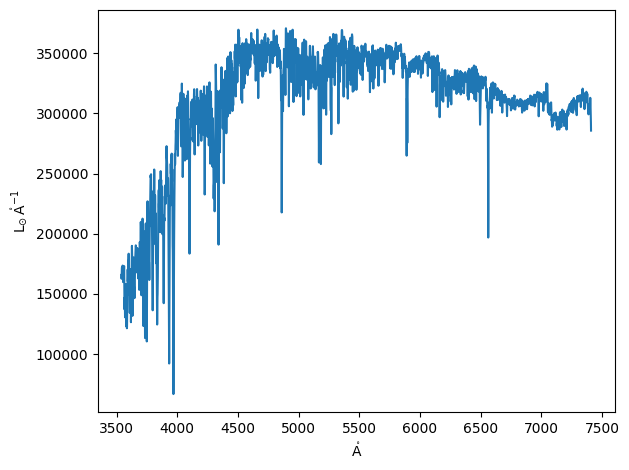

In [11]:
plt.plot(pred.spectral_axis, pred.flux)
plt.tight_layout()
plt.show()